In [34]:
# must set the kaggle api json file to the path
# AND MUST TAKE PART TO THE SPECIFIC COMPETITION
from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile
import os

api = KaggleApi()
api.authenticate()
# api.competition_download_file('sentiment-analysis-on-movie-reviews', f'train.tsv.zip', path='./')

for file in ['train.tsv', 'test.tsv']:
    api.competition_download_file('sentiment-analysis-on-movie-reviews', f'{file}.zip', path='./')

    with zipfile.ZipFile(f'{file}.zip', 'r') as zip_ref:
        zip_ref.extractall('./')

    os.remove(f'{file}.zip')

100%|██████████| 1.28M/1.28M [00:00<00:00, 1.51MB/s]


100%|██████████| 494k/494k [00:00<00:00, 713kB/s]

In [1]:
import pandas as pd

df = pd.read_csv('train.tsv', sep='\t')
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


<Axes: xlabel='Sentiment'>

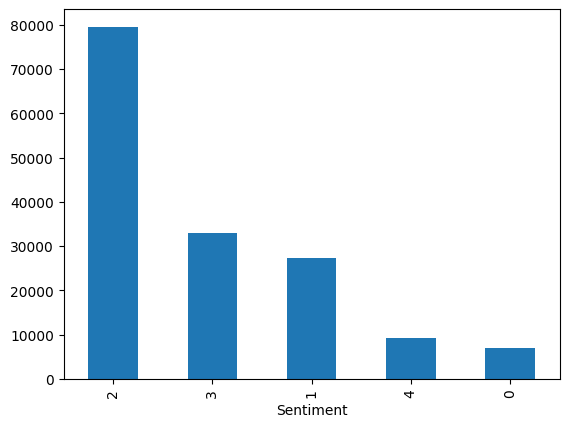

In [38]:
df['Sentiment'].value_counts().plot(kind='bar')
# labels: negative, somewhat negative, neutral, somewhat neutral, positive
# Let's check the distribution of sentiment classes across our data.

In [40]:
# We will be tokenizing this text to create two input tensors; our input IDs, and attention mask.
# We will contain our tensors within two numpy arrays, which will be of dimensions len(df) * 512 - the 512 is the sequence length of our tokenized sequences for BERT, and len(df) the number of samples in our dataset.

seq_len = 512
num_samples = len(df)
num_samples, seq_len

(156060, 512)

In [41]:
# Now we can begin tokenizing with a BertTokenizer, like so:


from transformers import BertTokenizer

# initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# tokenize - this time returning Numpy tensors
tokens = tokenizer(df['Phrase'].tolist(), max_length=seq_len, truncation=True,
                   padding='max_length', add_special_tokens=True,
                   return_tensors='np')

# np= numpy arrays

In [42]:
tokens['attention_mask']

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [43]:
tokens['input_ids'][:10]

array([[  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       ...,
       [  101, 13936, 25265, ...,     0,     0,     0],
       [  101, 13936, 25265, ...,     0,     0,     0],
       [  101, 15107,  1103, ...,     0,     0,     0]])

In [44]:
df['Phrase'].tolist(),

(['A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .',
  'A series of escapades demonstrating the adage that what is good for the goose',
  'A series',
  'A',
  'series',
  'of escapades demonstrating the adage that what is good for the goose',
  'of',
  'escapades demonstrating the adage that what is good for the goose',
  'escapades',
  'demonstrating the adage that what is good for the goose',
  'demonstrating the adage',
  'demonstrating',
  'the adage',
  'the',
  'adage',
  'that what is good for the goose',
  'that',
  'what is good for the goose',
  'what',
  'is good for the goose',
  'is',
  'good for the goose',
  'good',
  'for the goose',
  'for',
  'the goose',
  'goose',
  'is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .',
  'is also good for the gander , some of which occ

In [45]:
with open('movie-xids.npy', 'wb') as f:
    np.save(f, tokens['input_ids'])
with open('movie-xmask.npy', 'wb') as f:
    np.save(f, tokens['attention_mask'])

In [46]:

del tokens

In [47]:
# first extract sentiment column
arr = df['Sentiment'].values

In [48]:
arr

array([1, 2, 2, ..., 3, 2, 2], dtype=int64)

In [49]:
# one hot encoding
labels = np.zeros((num_samples, arr.max()+1))
labels.shape

(156060, 5)

In [50]:
# one hot encoding
labels[np.arange(num_samples), arr] = 1

labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [51]:
with open('movie-labels.npy', 'wb') as f:
    np.save(f, labels)

In [1]:
# Load all the dataset and labels from the files
import torch
import numpy as np

with open('movie-xids.npy', 'rb') as f:
    Xids = np.load(f, allow_pickle=True)
with open('movie-xmask.npy', 'rb') as f:
    Xmask = np.load(f, allow_pickle=True)
with open('movie-labels.npy', 'rb') as f:
    labels = np.load(f, allow_pickle=True)

In [2]:
import tensorflow as tf
# insert data as a tuple
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

dataset.take(1)

<TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.int32, name=None), TensorSpec(shape=(512,), dtype=tf.int32, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [3]:
def map_func(input_ids, masks, labels):
    # we convert our three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

# then we use the dataset map method to apply this transformation
dataset = dataset.map(map_func)

dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.int32, name=None)}, TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [4]:
batch_size = 16

dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)

dataset.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

In [5]:
split = 0.9
# we need to calculate how many batches must be taken to create 90% training set
size = int((Xids.shape[0] / batch_size) * split)

size

8778

In [7]:
train_ds = dataset.take(size)
val_ds = dataset.skip(size)

# free up memory
del dataset

NameError: name 'dataset' is not defined

In [8]:
tf.data.experimental.save(train_ds, 'train')
tf.data.experimental.save(val_ds, 'val')

Instructions for updating:
Use `tf.data.Dataset.save(...)` instead.


In [59]:
train_ds.element_spec

({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None),
  'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.int32, name=None)},
 TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

In [9]:
val_ds.element_spec == train_ds.element_spec

True

In [10]:
ds = tf.data.experimental.load('train', element_spec=train_ds.element_spec)

Instructions for updating:
Use `tf.data.Dataset.load(...)` instead.


In [17]:

from transformers import TFAutoModel

bert = TFAutoModel.from_pretrained('bert-base-cased')
# we can view the model using the summary method
bert.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "tf_bert_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [18]:
import tensorflow as tf

# two input layers, we ensure layer name variables match to dictionary keys in TF dataset
input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int32')

# we access the transformer model within our bert object using the bert attribute (eg bert.bert instead of bert)
embeddings = bert.bert(input_ids, attention_mask=mask)[1]  # access final activations (alread max-pooled) [1]
# convert bert embeddings into 5 output classes
x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(x)

In [21]:
# initialize model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# (optional) freeze bert layer
model.layers[2].trainable = False

# print out model summary
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                         

In [23]:
optimizer = tf.keras.optimizers.Adam(lr=1e-5, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

In [24]:
element_spec = ({'input_ids': tf.TensorSpec(shape=(16, 512), dtype=tf.float64, name=None),
                 'attention_mask': tf.TensorSpec(shape=(16, 512), dtype=tf.float64, name=None)},
                tf.TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

# load the training and validation sets
train_ds = tf.data.experimental.load('train', element_spec=element_spec)
val_ds = tf.data.experimental.load('val', element_spec=element_spec)

# view the input format
train_ds.take(1)

<TakeDataset element_spec=({'input_ids': TensorSpec(shape=(16, 512), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(16, 512), dtype=tf.float64, name=None)}, TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))>

In [25]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

Epoch 1/3


ResourceExhaustedError: Graph execution error:

Detected at node 'model_2/bert/encoder/layer_._9/attention/self/dropout_65/dropout/random_uniform/RandomUniform' defined at (most recent call last):
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\tzim3\AppData\Local\Temp\ipykernel_2504\1377320828.py", line 1, in <module>
      history = model.fit(
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\transformers\modeling_tf_utils.py", line 753, in run_call_with_unpacked_inputs
      mismatched_keys.update(mismatched_keys_set)
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 862, in call
      encoder_outputs = self.encoder(
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 548, in call
      for i, layer_module in enumerate(self.layer):
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 554, in call
      layer_outputs = layer_module(
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 464, in call
      self_attention_outputs = self.attention(
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 380, in call
      self_outputs = self.self_attention(
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\transformers\models\bert\modeling_tf_bert.py", line 323, in call
      attention_probs = self.dropout(inputs=attention_probs, training=training)
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\keras\layers\regularization\dropout.py", line 116, in call
      output = control_flow_util.smart_cond(
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\keras\layers\regularization\dropout.py", line 112, in dropped_inputs
      return self._random_generator.dropout(
    File "C:\Users\tzim3\anaconda3\envs\Alpha\lib\site-packages\keras\backend.py", line 2162, in dropout
      return tf.nn.dropout(
Node: 'model_2/bert/encoder/layer_._9/attention/self/dropout_65/dropout/random_uniform/RandomUniform'
OOM when allocating tensor with shape[16,12,512,512] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu
	 [[{{node model_2/bert/encoder/layer_._9/attention/self/dropout_65/dropout/random_uniform/RandomUniform}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_36609]

In [ ]:
model.save('sentiment_model')

In [2]:
import tensorflow as tf

In [5]:
import torch
print(torch.__version__)

2.0.0+cpu


LOAD AND PREDICT SECTION

In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model('sentiment_model')
# view model architecture to confirm we have save and loaded correctly
model.summary()

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def prep_data(text):
    tokens = tokenizer.encode_plus(text, max_length=512,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')
    # tokenizer returns int32 tensors, we need to return float64, so we use tf.cast
    return {'input_ids': tf.cast(tokens['input_ids'], tf.float64),
            'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)}

In [ ]:
probs = model.predict(prep_data("hello world"))[0]

probs

In [ ]:
import numpy as np

np.argmax(probs)

In [ ]:
import pandas as pd

# so we can see full phrase
pd.set_option('display.max_colwidth', None)

df = pd.read_csv('test.tsv', sep='\t')
df.head()

In [ ]:
df = df.drop_duplicates(subset=['SentenceId'], keep='first')
df.head()

In [ ]:
df['Sentiment'] = None

for i, row in df.iterrows():
    # get token tensors
    tokens = prep_data(row['Phrase'])
    # get probabilities
    probs = model.predict(tokens)
    # find argmax for winning class
    pred = np.argmax(probs)
    # add to dataframe
    df.at[i, 'Sentiment'] = pred

df.head()

In [ ]:
df.tail()